In [1]:
import sys
sys.path.insert(0, '/home/oscarwu/code/chemprop_developing')

import pickle as pkl
import numpy as np
import pandas as pd

In [19]:
# load an example
df_smi = pd.read_csv('esol.csv')
df_smi.iloc[[7]]

,smiles,logSolubility
7,CC#N,0.26


In [20]:
smiles = df_smi.iloc[[7]]['smiles'].values.tolist()

In [21]:
smiles

['CC#N']

In [22]:
from chemprop.features.utils import load_features, load_valid_atom_or_bond_features
from chemprop.models.mpn import mask_features_extra_batch, mask_features_extra

In [23]:
bond_features = [load_valid_atom_or_bond_features('esol_wb97xd_bond_RBF_features.pkl', smiles)[7]]

In [24]:
atom_descriptors = [load_valid_atom_or_bond_features('esol_wb97xd_atom_RBF_features.pkl', smiles)[7]]

In [25]:
mol_features = [load_features("esol_wb97xd_molecule_features.csv")[7].reshape(1, -1)]

In [39]:
# Example SHAP Analysis
# Imports
from chemprop.args import TrainArgs
from chemprop.models.model import MoleculeModel

import torch
from chemprop.utils import load_checkpoint, load_scalers
from chemprop.features import set_extra_bond_fdim

from rdkit import Chem
from chemprop.rdkit import make_mol

# Load TrainArgs and MoleculeModel
path = "/home/oscarwu/code/chemprop_developing/developing/shap_v1/data/model.pt"
state = torch.load(path, map_location=lambda storage, loc: storage)
train_args = TrainArgs()
train_args.from_dict(vars(state["args"]), skip_unsettable=True)
set_extra_bond_fdim(train_args.bond_features_size)
model = load_checkpoint(path)
scalers = load_scalers(path)

# Create a MoleculeModel Wrapper
class MoleculeModelWrapper:
    def __init__(self, model, train_args, scalers, smiles, shap, features_batch, 
                 atom_descriptors_batch, atom_features_batch, bond_descriptors_batch, bond_features_batch):
        self.model = model.eval()
        self.train_args = train_args
        self.target_scaler, self.mol_feature_scaler, _, _, _ = scalers
        self.smiles = smiles
        self.shap = shap
        if features_batch is not None:
            self.features_batch = [self.mol_feature_scaler.transform(feat) for feat in features_batch]
        else:
            self.features_batch = None      
        self.atom_descriptors_batch = atom_descriptors_batch
        self.atom_features_batch = atom_features_batch
        self.bond_descriptors_batch = bond_descriptors_batch
        self.bond_features_batch = bond_features_batch
        
        self.batch = None
        self.extra_keep_features_batch = None
        self.extra_atom_keep_descriptors_batch = None
        self.extra_bond_keep_descriptors_batch = None
        self.extra_atom_keep_features_batch = None
        self.extra_bond_keep_features_batch = None
        self.chemprop_atom_keep_features = None
        self.chemprop_bond_keep_features = None
        

    def __call__(self, feature_choices):
        if isinstance(feature_choices, np.ndarray):
            if len(feature_choices.shape) == 1:
                feature_choices = feature_choices.reshape(1, -1)
                
        result = []
        
        for feature_choice in feature_choices:
        
            self.batch = [[make_mol(s=smi, keep_h=True, add_h=True, keep_atom_map=True)] for smi in self.smiles]
            self.extra_keep_features_batch = [feature_choice[0:20]] # 20 extra molecular features
            self.extra_atom_keep_descriptors_batch = [feature_choice[20:33]] # 13 atom descriptors
            self.extra_bond_keep_descriptors_batch = None # 0 bond descriptors
            self.extra_atom_keep_features_batch = None # 0 atom features
            self.extra_bond_keep_features_batch = [feature_choice[33:37]] # 4 bond features
            self.chemprop_atom_keep_features = feature_choice[37:45] # 8 chemprop atom features
            self.chemprop_bond_keep_features = feature_choice[45:49] # 4 chemprop bond features
            
            # this is from forward in original MoleculeModel in model.py
            output = self.model(batch=self.batch, 
                                features_batch=self.features_batch, 
                                atom_descriptors_batch=self.atom_descriptors_batch, 
                                atom_features_batch=self.atom_features_batch, 
                                bond_descriptors_batch=self.bond_descriptors_batch, 
                                bond_features_batch=self.bond_features_batch, 
                                constraints_batch=None,
                                bond_types_batch=None,
                                shap=self.shap, 
                                extra_keep_features_batch=self.extra_keep_features_batch, 
                                extra_atom_keep_descriptors_batch=self.extra_atom_keep_descriptors_batch, 
                                extra_bond_keep_descriptors_batch=self.extra_bond_keep_descriptors_batch, 
                                extra_atom_keep_features_batch=self.extra_atom_keep_features_batch, 
                                extra_bond_keep_features_batch=self.extra_bond_keep_features_batch, 
                                chemprop_atom_keep_features=self.chemprop_atom_keep_features, 
                                chemprop_bond_keep_features=self.chemprop_bond_keep_features)
        
            # xform = self.target_scaler.inverse_transform(output.item()).item()
            # xform = np.array(xform, ndmin=2)
            # result.append(xform)
            result.append(output.item())
        
        return np.array(result).reshape(len(feature_choices), -1)
        

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "encoder.encoder.0.atom_descriptors_layer.weight".
Loading pretrained parameter "encoder.encoder.0.atom_descriptors_layer.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Loading pretrained parameter "readout.7.weight".
Loading pretrained parameter "readout.7.bias".


In [40]:
model_wrapper = MoleculeModelWrapper(model=model, 
                                     train_args=train_args, 
                                     scalers=scalers, 
                                     smiles=smiles, 
                                     shap=True, 
                                     features_batch=mol_features, 
                                     atom_descriptors_batch=atom_descriptors, 
                                     atom_features_batch=None, 
                                     bond_descriptors_batch=None, 
                                     bond_features_batch=bond_features)

In [41]:
# SHAP
from shap import PermutationExplainer
from copy import deepcopy

def binary_masker(binary_mask, x):
    masked_x = deepcopy(x)
    masked_x[binary_mask == 0] = 0
    return np.array([masked_x])

In [42]:
explainer = PermutationExplainer(model=model_wrapper, masker=binary_masker)

In [43]:
feature_choice = np.array([[1]*49])

In [44]:
model_wrapper(feature_choice)

array([[1.48271787]])

In [45]:
explanation = explainer(feature_choice, max_evals=1000)
print(explanation)

.values =
array([[-0.06818981, -0.04401359,  0.02196456,  0.00923617,  0.03426105,
         0.04075664,  0.04390598,  0.04572545,  0.03361975,  0.00688102,
         0.04961135,  0.06198753,  0.0522531 ,  0.05856621,  0.05618662,
         0.06278754,  0.06791877,  0.02700041,  0.05307844, -0.02680674,
         0.02018082,  0.0248697 ,  0.0122441 ,  0.14343833,  0.10907255,
         0.01157437,  0.00165047,  0.05356755,  0.00048578,  0.03099726,
         0.01282796,  0.00185689,  0.01182191, -0.07983887,  0.05499808,
         0.00592623,  0.01910195,  0.02992556,  0.02825646,  0.00939235,
         0.01078379,  0.00434553, -0.00192115,  0.        , -0.00033873,
        -0.01393093,  0.        ,  0.        ,  0.00118175]])

.base_values =
array([[0.3935177]])

.data =
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1]])


In [46]:
explanation = explainer(feature_choice, max_evals=1000)
print(explanation)

.values =
array([[-0.06155069, -0.04844916,  0.02200305,  0.00049069,  0.03525033,
         0.02890787,  0.04584529,  0.03914689,  0.03463541,  0.00912757,
         0.04134692,  0.06294268,  0.05764132,  0.06976731,  0.0597169 ,
         0.06504496,  0.06100687,  0.03067488,  0.05578036, -0.0267111 ,
         0.02062687,  0.02388487,  0.01189248,  0.14701903,  0.11027023,
         0.01168847,  0.00109532,  0.05328011,  0.00093189,  0.03268777,
         0.01209083,  0.00168549,  0.01174097, -0.08073615,  0.0588346 ,
         0.00975118,  0.01592887,  0.02975714,  0.02488734,  0.0077985 ,
         0.00883992,  0.00430841,  0.00080982,  0.        , -0.00042859,
        -0.01563647,  0.        ,  0.        ,  0.00357294]])

.base_values =
array([[0.3935177]])

.data =
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1]])


In [47]:
import shap

In [54]:
explanation

.values =
0

.base_values =
array([[0.3935177]])

.data =
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1]])

In [48]:
explanation.values

array([[-0.06155069, -0.04844916,  0.02200305,  0.00049069,  0.03525033,
         0.02890787,  0.04584529,  0.03914689,  0.03463541,  0.00912757,
         0.04134692,  0.06294268,  0.05764132,  0.06976731,  0.0597169 ,
         0.06504496,  0.06100687,  0.03067488,  0.05578036, -0.0267111 ,
         0.02062687,  0.02388487,  0.01189248,  0.14701903,  0.11027023,
         0.01168847,  0.00109532,  0.05328011,  0.00093189,  0.03268777,
         0.01209083,  0.00168549,  0.01174097, -0.08073615,  0.0588346 ,
         0.00975118,  0.01592887,  0.02975714,  0.02488734,  0.0077985 ,
         0.00883992,  0.00430841,  0.00080982,  0.        , -0.00042859,
        -0.01563647,  0.        ,  0.        ,  0.00357294]])

In [50]:
type(explanation)

shap._explanation.Explanation

In [56]:
explanation.values = np.array([[-0.06155069, -0.04844916,  0.02200305,  0.00049069,  0.03525033,
         0.02890787,  0.04584529,  0.03914689,  0.03463541,  0.00912757,
         0.04134692,  0.06294268,  0.05764132,  0.06976731,  0.0597169 ,
         0.06504496,  0.06100687,  0.03067488,  0.05578036, -0.0267111 ,
         0.02062687,  0.02388487,  0.01189248,  0.14701903,  0.11027023,
         0.01168847,  0.00109532,  0.05328011,  0.00093189,  0.03268777,
         0.01209083,  0.00168549,  0.01174097, -0.08073615,  0.0588346 ,
         0.00975118,  0.01592887,  0.02975714,  0.02488734,  0.0077985 ,
         0.00883992,  0.00430841,  0.00080982,  0.        , -0.00042859,
        -0.01563647,  0.        ,  0.        ,  0.00357294]])

In [75]:
explanation.values[0][23]

0.14701903

In [73]:
np.sum(explanation.values)

1.08920019

In [74]:
1.08920019 + 0.3935177

1.48271789

In [60]:
explanation.base_values

array([[0.3935177]])

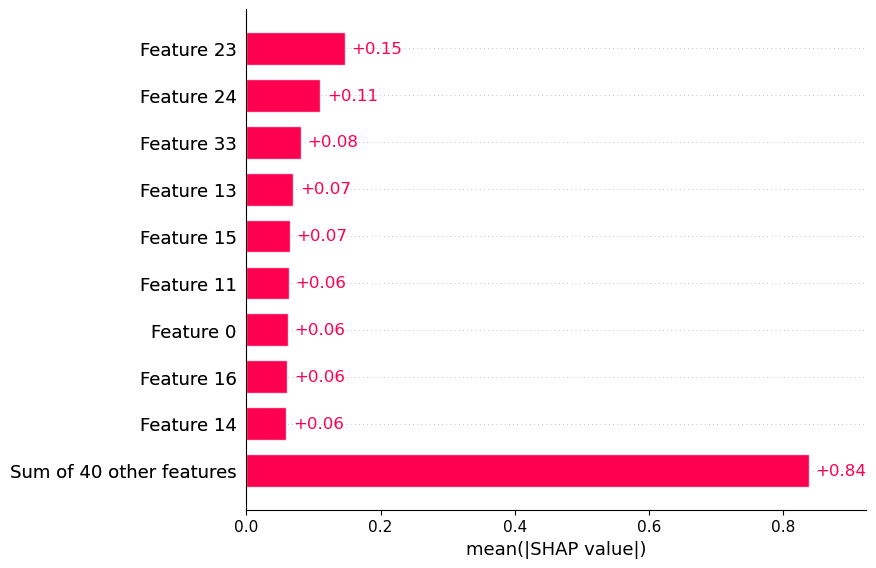

In [57]:
shap.plots.bar(explanation)

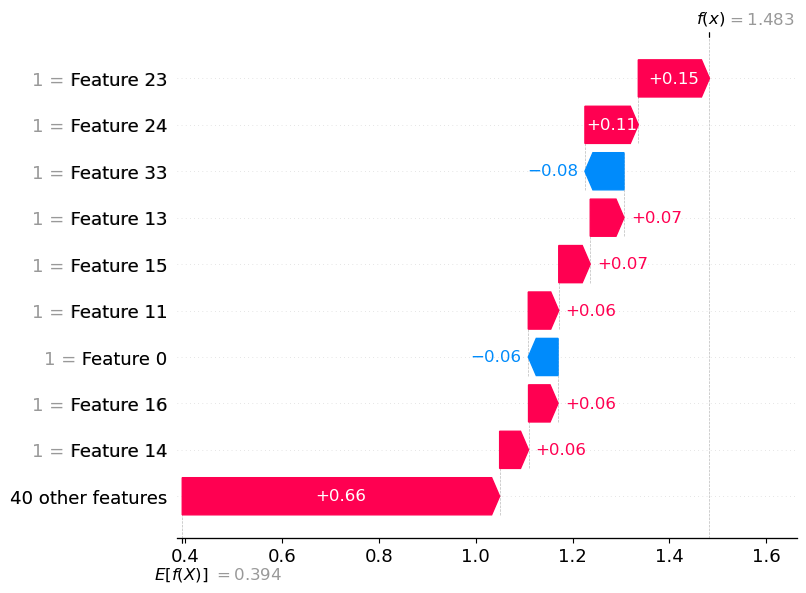

In [70]:
shap.plots.waterfall(explanation[0])

In [71]:
explanation

.values =
array([[-0.06155069, -0.04844916,  0.02200305,  0.00049069,  0.03525033,
         0.02890787,  0.04584529,  0.03914689,  0.03463541,  0.00912757,
         0.04134692,  0.06294268,  0.05764132,  0.06976731,  0.0597169 ,
         0.06504496,  0.06100687,  0.03067488,  0.05578036, -0.0267111 ,
         0.02062687,  0.02388487,  0.01189248,  0.14701903,  0.11027023,
         0.01168847,  0.00109532,  0.05328011,  0.00093189,  0.03268777,
         0.01209083,  0.00168549,  0.01174097, -0.08073615,  0.0588346 ,
         0.00975118,  0.01592887,  0.02975714,  0.02488734,  0.0077985 ,
         0.00883992,  0.00430841,  0.00080982,  0.        , -0.00042859,
        -0.01563647,  0.        ,  0.        ,  0.00357294]])

.base_values =
array([[0.3935177]])

.data =
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1]])